In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000000000000000000000

import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile
import stingray.gti as sting_gti
import stingray.pulse.accelsearch as accelsearch
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *




/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/bispectrum.py:10: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/hendrics/io.py:24: UserWarning: Warning! NetCDF is not available. Using pickle format.
  warnings.warn(msg)
/Users/sean/opt/

# Soft State

## Setup

Working on Macbook


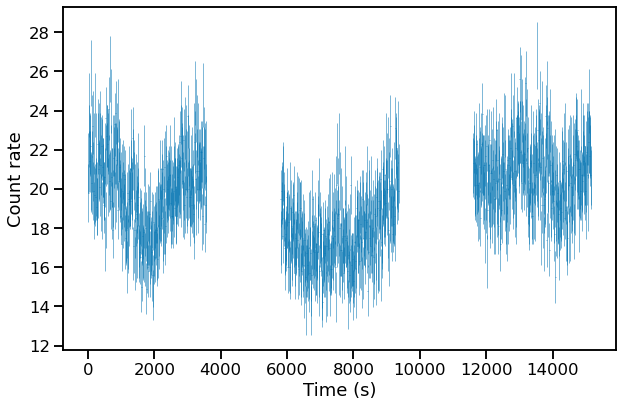

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/MAXI_J1848m015/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/MAXI_J1848m015/'
    
OBSID='90601340002'

products_dir = root_dir + OBSID + '_pipe_out/'
plot_dir = root_dir + 'figures/'

centroid_A = [573.47525, 524.49281]
centroid_B = [576.46113, 518.50724]
extraction_radius = 48.818048
# print(centroid_A)
# print(centroid_B)
# print(extraction_radius)

events = extract_events(products_dir + 'nu' + OBSID + 'A06_cl_bc.evt', \
            products_dir + 'nu' + OBSID + 'B06_cl_bc.evt')


events[0].centroid=centroid_A
events[0].radius=extraction_radius
events[1].centroid=centroid_B
events[1].radius=extraction_radius

PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = 1909   # 78.0 keV

curve_A = events[0].to_lc(dt = 10, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius)
curve_B = events[1].to_lc(dt = 10, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius)

total_curve = sum_lc(curve_A, curve_B)
start_time = np.min(total_curve.time) - total_curve.dt/2

plt.figure(figsize=(9,6))
plt.errorbar(total_curve.time-start_time, total_curve.countrate, xerr=total_curve.dt/2, yerr=total_curve.countrate_err, ls='', lw=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.tight_layout()




In [3]:
plt.ion()
bin_time = 1/4096
split_time = 64
buff = False
lc_buff_size = 60
bkg_bin = 32
    
### Setup
plt.ion()
PI_min = eV_to_PI(3000)     # 3.0 keV
PI_max = eV_to_PI(78000)   # 78.0 keV

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius)


### Calculate CPDS
averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')
ntrial = len(averaged_cross.freq)

print(averaged_cross.freq[0] - averaged_cross.df/2)
print(averaged_cross.freq[-1] + averaged_cross.df/2)

165it [00:22,  7.18it/s]
165it [00:19,  8.43it/s]
165it [00:18,  8.89it/s]


0.0078125
2047.9921875


In [5]:
### Plot CPDS
# f_res = 0.3
# averaged_cross_log = averaged_cross.rebin_log(f=f_res)
# averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross.freq, averaged_cross.power, xerr=averaged_cross.df/2, yerr=averaged_cross.power_err, fmt='none', color='black', lw=0.5, rasterized=True)
# plt.step(np.concatenate([averaged_cross.freq-averaged_cross.df/2, [averaged_cross.freq[-1]+averaged_cross.df/2]]), \
#          np.concatenate([averaged_cross.power, [(averaged_cross.power)[-1]]]), where='post', color='black', lw=0.5, rasterized=True)
# plt.xscale('log')
plt.ylim(bottom=2e-2)
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{P_{\nu}\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's_unbinned.pdf', dpi=100)
plt.close()

# plt.figure(figsize=(9,6))
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', color='black', lw=0.5)
# plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
#          np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
# plt.xscale('log')
# plt.ylim((1e-5,0.1))
# plt.yscale('log')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
# plt.tight_layout()
# # plt.show()
# plt.savefig(plot_dir + OBSID + '_CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
# plt.close()

# plt.figure(figsize=(9,6))
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, fmt='none', color='black', lw=0.5)
# plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
#          np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
# plt.xscale('log')
# plt.ylim((1e-5,10))
# plt.yscale('log')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
# plt.tight_layout()
# # plt.show()
# plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
# plt.close()



## Accelerated Search

100%|████████████████████████████████████| 10000/10000 [01:19<00:00, 125.14it/s]


272143
43.93812892736301
31.678525542931034
0.03532695913611938615
0.02275927592759276
0.023478861351952734 +/- 0.006192172803702007
3.7916999567447207


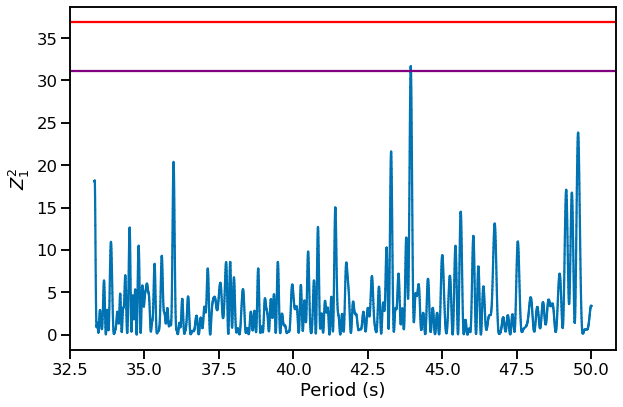

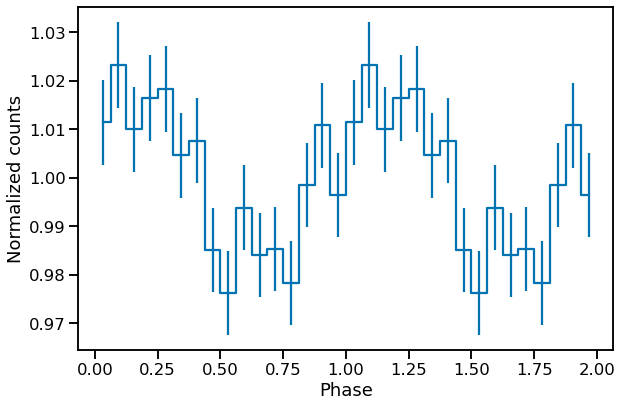

In [8]:
# fdots = np.concatenate([-np.flip(np.logspace(-12,-10, num=25)), [0.0], np.logspace(-12,-10, num=25)])
# fdots = -np.flip(np.logspace(-12,-11, num=50))
# print(fdots)
# f_grid, fd_grid, z_prob, z_stat, peak_bins, peak_profile, peak_err = efold_search_AandB(events[0], events[1], f_min=1/45, f_max=1/42.5, f_steps=1000, fdots=fdots, nbin = 16, pi_min = eV_to_PI(3000), pi_max = eV_to_PI(78000), return_peak=True, z_n=1)
f_grid, z_prob, z_stat, peak_bins, peak_profile, peak_err = efold_search_AandB(events[0], events[1], f_min=0.02, f_max=0.03, f_steps=10000, nbin = 16, pi_min = eV_to_PI(3000), pi_max = eV_to_PI(78000), return_peak=True, z_n=1)
print(ntrial + len(f_grid))
# f_grid, z_prob, z_stat, peak_bins, peak_profile, peak_err = efold_search_AandB(events[0], events[1], f_min=0.02, f_max=0.03, f_steps=10000, nbin = 16, pi_min = eV_to_PI(3000), pi_max = eV_to_PI(78000), return_peak=True, z_n=1)

z_prob = stats.z2_n_probability(z_stat, n=1, ntrial=len(f_grid) + ntrial)
plt.figure(figsize= (9,6))
plt.step(1/f_grid, z_stat, where='mid')
plt.axhline(stats.z2_n_detection_level(n=1, epsilon=1-0.9973, ntrial=len(f_grid) + ntrial), color='red')
plt.axhline(stats.z2_n_detection_level(n=1, epsilon=1-0.9545, ntrial=len(f_grid) + ntrial), color='purple')
plt.ylabel(r'$Z_1^2$')
plt.xlabel('Period (s)')
plt.tight_layout()
# plt.loglog()
plt.savefig(plot_dir + OBSID + '_Zsearch.pdf')
print(1/f_grid[np.argmax(z_stat)])

# print(np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape))

# plt.figure(figsize= (12,9))
# plt.pcolormesh(f_grid, fd_grid, np.log10(z_stat))
# plt.colorbar()
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('F_dot (Hz/s)')
# plt.text(f_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)], fd_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)], 'X', color='red')
# plt.tight_layout()

plt.figure(figsize= (9,6))
plt.errorbar(np.concatenate((peak_bins, peak_bins + 1.0)), np.concatenate((peak_profile, peak_profile))/np.mean(peak_profile), yerr=np.concatenate((peak_err, peak_err))/np.mean(peak_profile), ls='')
plt.step(np.concatenate((peak_bins, peak_bins + 1.0)), np.concatenate((peak_profile, peak_profile))/np.mean(peak_profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Phase')
plt.tight_layout()

PF = (np.max(peak_profile)-np.min(peak_profile))/(np.max(peak_profile) + np.min(peak_profile))

max_err = peak_err[np.argmax(peak_profile)]
min_err = peak_err[np.argmin(peak_profile)]
PF_err = np.sqrt(np.square((1-PF)*max_err) + np.square((1+PF)*min_err))/(np.max(peak_profile) + np.min(peak_profile))

print(np.max(z_stat))
print(np.min(z_prob))
print(f_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)])
# print(fd_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)])
print(str(PF) + ' +/- ' + str(PF_err))
print(PF/PF_err)



In [ ]:
phaseogr, phases, times, additional_info = \
            phaseogram(joined_ev.time, 0.0030989770445291917, return_plot=True, nph=64, nt=128)

plt.figure(figsize=(15, 15))
gs = GridSpec(2, 1, height_ratios=(1, 3))
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

mean_phases = (phases[:-1] + phases[1:]) / 2
plot_profile(mean_phases, np.sum(phaseogr, axis=1), ax=ax0)
# Note that we can pass arguments to plt.pcolormesh, in this case vmin
_ = plot_phaseogram(phaseogr, phases, times, ax=ax1, vmin=np.median(phaseogr))



# Hard State

## Setup

Working on Macbook


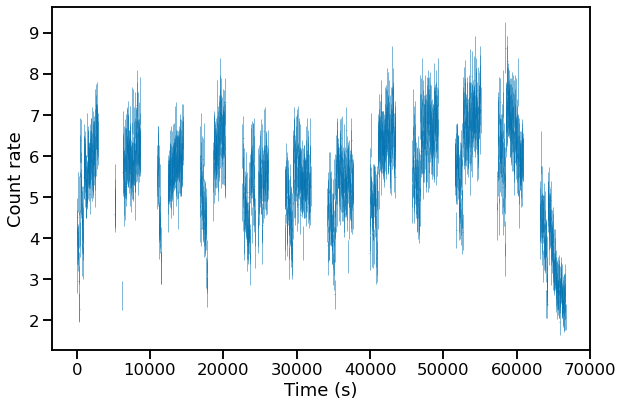

In [3]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/MAXI_J1848m015/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/MAXI_J1848m015/'
    
OBSID='90601341002'

products_dir = root_dir + OBSID + '_pipe_out/'
plot_dir = root_dir + 'figures/'

centroid_A = [508.44966, 496.38968]
centroid_B = [509.77448, 490.49662]
extraction_radius = 36.613536
# print(centroid_A)
# print(centroid_B)
# print(extraction_radius)

events = extract_events(products_dir + 'nu' + OBSID + 'A06_cl_bc.evt', \
            products_dir + 'nu' + OBSID + 'B06_cl_bc.evt')

events[0].centroid=centroid_A
events[0].radius=extraction_radius
events[1].centroid=centroid_B
events[1].radius=extraction_radius

PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = 1909   # 78.0 keV

curve_A = events[0].to_lc(dt = 25, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius)
curve_B = events[1].to_lc(dt = 25, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius)

total_curve = sum_lc(curve_A, curve_B)
start_time = np.min(total_curve.time) - total_curve.dt/2

plt.figure(figsize=(9,6))
plt.errorbar(total_curve.time-start_time, total_curve.countrate, xerr=total_curve.dt/2, yerr=total_curve.countrate_err, ls='', lw=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.tight_layout()



## Fast Timing

In [4]:
plt.ion()
bin_time = 1/4096
split_time = 64
buff = False
lc_buff_size = 60
bkg_bin = 32
    
### Setup
plt.ion()
PI_min = eV_to_PI(3000)     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = eV_to_PI(78000)   # 78.0 keV

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius)

### Calculate CPDS
averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')
ntrial = len(averaged_cross.freq)
# averaged_cross.power = averaged_cross.power * np.square((1/(1-0.0025*(curve_A.meanrate))) * ((src_rate + (bkg_rate*area_ratio))/(src_rate)))
# averaged_cross.power_err = averaged_cross.power_err * np.square((1/(1-0.0025*(curve_A.meanrate))) * ((src_rate + (bkg_rate*area_ratio))/(src_rate)))


605it [01:29,  6.77it/s]
605it [01:17,  7.80it/s]
605it [01:21,  7.44it/s]


In [6]:
### Plot CPDS
# f_res = 0.1
# averaged_cross_log = averaged_cross.rebin_log(f=f_res)
# averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross.freq, averaged_cross.power, xerr=averaged_cross.df/2, yerr=averaged_cross.power_err, fmt='none', color='black', lw=0.5, rasterized=True)
# plt.xscale('log')
plt.ylim(bottom=6e-2)
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{P_{\nu}\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's_unbinned.pdf', dpi=100)
plt.close()

# plt.figure(figsize=(9,6))
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', color='black', lw=0.5)
# plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
#          np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
# plt.xscale('log')
# plt.ylim((1e-4,2))
# plt.yscale('log')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
# plt.tight_layout()
# # plt.show()
# plt.savefig(plot_dir + OBSID + '_CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
# plt.close()

# plt.figure(figsize=(9,6))
# plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, fmt='none', color='black', lw=0.5)
# plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
#          np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
# plt.xscale('log')
# plt.ylim((1e-4,2))
# plt.yscale('log')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
# plt.tight_layout()
# # plt.show()
# plt.savefig(plot_dir + OBSID + '_CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
# plt.close()



## Accelerated Search

100%|████████████████████████████████████| 10000/10000 [01:24<00:00, 118.53it/s]


272143
42.16141001855288
25.772843199898645
0.49798320292696007035
0.023718371837183717
0.02514378410263973 +/- 0.006069959677760649
4.142331323017267


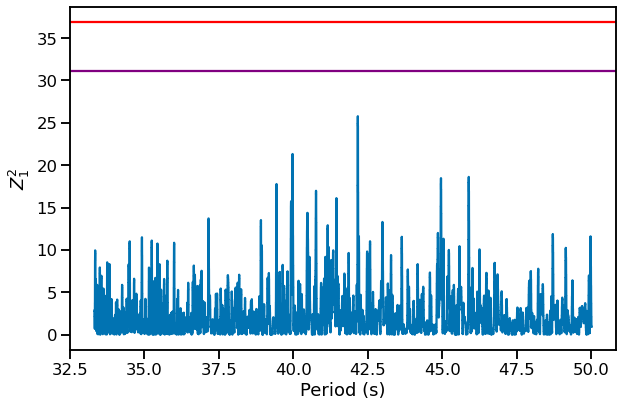

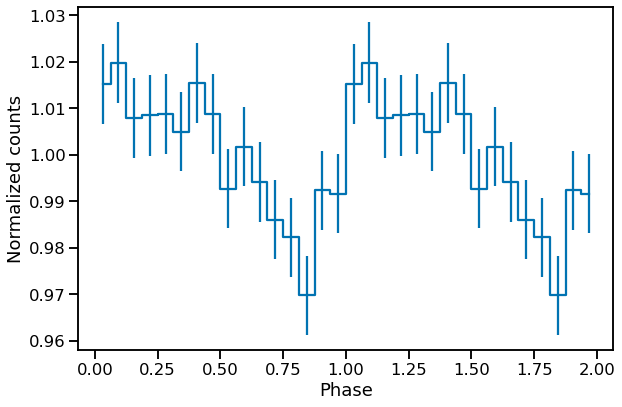

In [4]:
# fdots = np.concatenate([-np.flip(np.logspace(-12,-10, num=25)), [0.0], np.logspace(-12,-10, num=25)])
# fdots = -np.flip(np.logspace(-12,-11, num=50))
# print(fdots)
# f_grid, fd_grid, z_prob, z_stat, peak_bins, peak_profile, peak_err = efold_search_AandB(events[0], events[1], f_min=1/45, f_max=1/42.5, f_steps=1000, fdots=fdots, nbin = 16, pi_min = eV_to_PI(3000), pi_max = eV_to_PI(78000), return_peak=True, z_n=1)
f_grid, z_prob, z_stat, peak_bins, peak_profile, peak_err = efold_search_AandB(events[0], events[1], f_min=0.02, f_max=0.03, f_steps=10000, nbin = 16, pi_min = eV_to_PI(3000), pi_max = eV_to_PI(78000), return_peak=True, z_n=1)
print(ntrial + len(f_grid))
# f_grid, z_prob, z_stat, peak_bins, peak_profile, peak_err = efold_search_AandB(events[0], events[1], f_min=0.02, f_max=0.03, f_steps=10000, nbin = 16, pi_min = eV_to_PI(3000), pi_max = eV_to_PI(78000), return_peak=True, z_n=1)

z_prob = stats.z2_n_probability(z_stat, n=1, ntrial=len(f_grid) + ntrial)
plt.figure(figsize= (9,6))
plt.step(1/f_grid, z_stat, where='mid')
plt.axhline(stats.z2_n_detection_level(n=1, epsilon=1-0.9973, ntrial=len(f_grid) + ntrial), color='red')
plt.axhline(stats.z2_n_detection_level(n=1, epsilon=1-0.9545, ntrial=len(f_grid) + ntrial), color='purple')
plt.ylabel(r'$Z_1^2$')
plt.xlabel('Period (s)')
plt.tight_layout()
# plt.loglog()
plt.savefig(plot_dir + OBSID + '_Zsearch.pdf')
print(1/f_grid[np.argmax(z_stat)])

# print(np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape))

# plt.figure(figsize= (12,9))
# plt.pcolormesh(f_grid, fd_grid, np.log10(z_stat))
# plt.colorbar()
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('F_dot (Hz/s)')
# plt.text(f_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)], fd_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)], 'X', color='red')
# plt.tight_layout()

plt.figure(figsize= (9,6))
plt.errorbar(np.concatenate((peak_bins, peak_bins + 1.0)), np.concatenate((peak_profile, peak_profile))/np.mean(peak_profile), yerr=np.concatenate((peak_err, peak_err))/np.mean(peak_profile), ls='')
plt.step(np.concatenate((peak_bins, peak_bins + 1.0)), np.concatenate((peak_profile, peak_profile))/np.mean(peak_profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Phase')
plt.tight_layout()

PF = (np.max(peak_profile)-np.min(peak_profile))/(np.max(peak_profile) + np.min(peak_profile))

max_err = peak_err[np.argmax(peak_profile)]
min_err = peak_err[np.argmin(peak_profile)]
PF_err = np.sqrt(np.square((1-PF)*max_err) + np.square((1+PF)*min_err))/(np.max(peak_profile) + np.min(peak_profile))

print(np.max(z_stat))
print(np.min(z_prob))
print(f_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)])
# print(fd_grid[np.unravel_index(np.argmax(z_stat, axis=None), z_stat.shape)])
print(str(PF) + ' +/- ' + str(PF_err))
print(PF/PF_err)


